In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [10]:
data = pd.read_csv('avy_bulletin_data.csv', low_memory=False)
col_date = [col for col in data.columns if "date" in col]
data[col_date] = data[col_date].apply(lambda x: pd.to_datetime(x))

In [11]:
data.head()

,avy_0_date,avy_0_provoquer,avy_0_spontane,avy_1_date,avy_1_provoquer,avy_1_spontane,avy_2_date,avy_2_provoquer,avy_2_spontane,avy_3_date,...,info_id,info_massif,info_producteur,cm_qualite_texte,cm_stabilite_texte,td_0_date,td_0_valeur,td_1_date,td_1_valeur,nombre
0,2016-12-06,0.0,0.0,2016-12-07,0.0,0.0,2016-12-08,0.0,0.0,2016-12-09,...,1.0,CHABLAIS,CDM741,On peut chausser les skis entre 1700 et 2000 m...,Plus bas que 2000 m : l'enneigement est très r...,2016-12-14,0,2016-12-15,0,NaN
1,2016-12-06,0.0,0.0,2016-12-07,0.0,0.0,2016-12-08,0.0,0.0,2016-12-09,...,3.0,MONT-BLANC,CDM741,On peut chausser les skis entre 1700 et 2000 m...,Plus bas que 2000 m : l'enneigement est très r...,2016-12-14,0,2016-12-15,0,NaN
2,2016-12-07,0.0,0.0,2016-12-08,0.0,0.0,2016-12-09,0.0,0.0,2016-12-10,...,1.0,CHABLAIS,CDM741,"Dans les versants peu ensoleillés, on peut par...",Plus bas que 2000 m : l'enneigement est très r...,2016-12-15,0,2016-12-16,0,NaN
3,2016-12-07,0.0,0.0,2016-12-08,0.0,0.0,2016-12-09,0.0,0.0,2016-12-10,...,3.0,MONT-BLANC,CDM741,"Dans les versants peu ensoleillés, on peut par...",Plus bas que 2000 m : l'enneigement est très r...,2016-12-15,0,2016-12-16,0,NaN
4,2016-12-08,0.0,0.0,2016-12-09,0.0,0.0,2016-12-10,0.0,0.0,2016-12-11,...,1.0,CHABLAIS,CDM741,Versants peu ensoleillés : on peut chausser ve...,"Plus bas que 2000 m : enneigement très réduit,...",2016-12-16,0,2016-12-17,0,NaN


In [12]:
stat_danger = data[['dg_risquemaxi']].groupby('dg_risquemaxi').size()
stat_danger

dg_risquemaxi
1.0     583
2.0    3174
3.0    3760
4.0     788
5.0      50
dtype: int64

# Distribution of avy danger by categories (unbalanced setting)

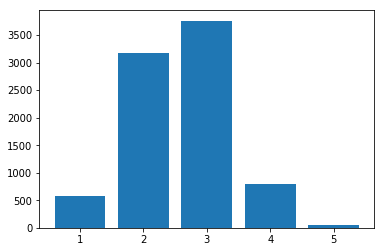

In [13]:
fig, ax = plt.subplots()
ax.bar(list(range(1,len(stat_danger) + 1)), stat_danger)
ax.set_xticks(list(range(1, len(stat_danger) + 1)))

In [14]:
# Presence of reports is uniform over sectors

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34],
 <a list of 35 Text xticklabel objects>)

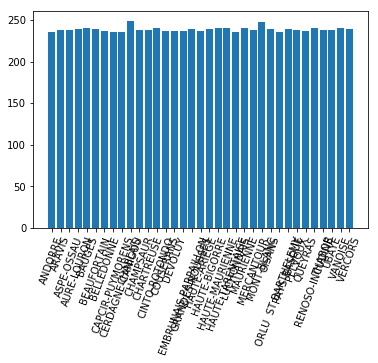

In [15]:
stat_massif = data.groupby('info_massif')['info_massif'].size()
fig, ax = plt.subplots()
ax.bar(stat_massif.index, stat_massif)
plt.xticks(rotation=70)

## Consistency between forecast from day t to day t+1

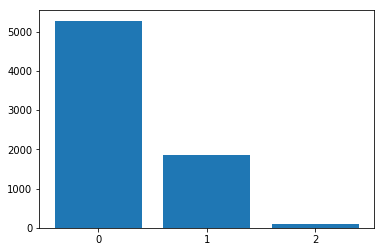

In [16]:
stats = []
for i, sector in enumerate(data['info_massif'].unique()):
    df = data[data['info_massif'] == sector].sort_values('info_datevalidite')
    df['info_datevalidite+1'] = df['info_datevalidite'].shift(1)
    df = df[(df['info_datevalidite+1'] - df['info_datevalidite'] == '-1 days')]
    df['dg_risquemaxi+1'] = df['dg_risquemaxi'].shift(1)
    df['offset_dg'] = np.abs(df['dg_risquemaxi+1'] -  df['dg_risquemaxi'])
    stat = df[['offset_dg']].groupby('offset_dg').size().to_frame()
    stats.append(stat)

pd_stats = pd.concat(stats, axis=1).sum(axis=1)
fig, ax = plt.subplots()
ax.bar(pd_stats.index, pd_stats)
ax.set_xticks(pd_stats.index)

We can see here that there are around 5000 days where foreacast t+1 = forecast t, around 2000 where forecast t+1 = forecast t (+/-) 1 category and less that 100 days where forecast t+1 = forecast t (+/-) 2 category.
There is a strong consistency between foreacasted days.

# Repartition of avy danger between slope orientation

ValueError: unknown locale: UTF-8

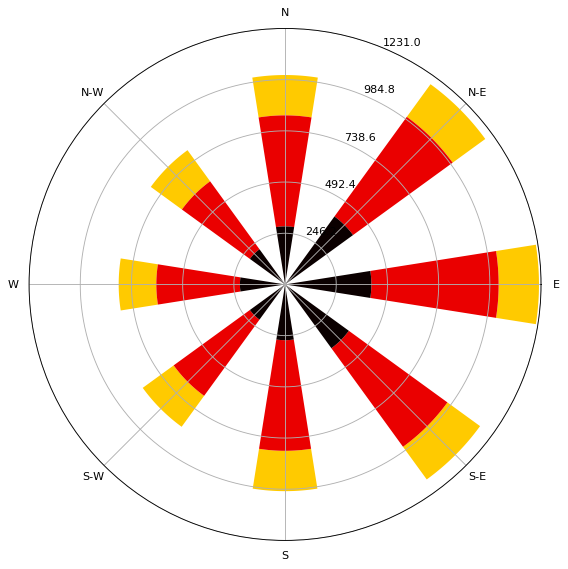

In [17]:
pente_danger_col = [col for col in data.columns if 'dg' in col and 'pente' in col]


df = data[pente_danger_col + ['dg_risquemaxi']]
df = df.dropna()

avg_dg_per_slope_orientation = df.groupby('dg_risquemaxi').mean()

from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Create wind speed and direction variables
direction = []
danger = []
for dir_, col  in {45: 'dg_pente_nw', 90: 'dg_pente_n', 135: 'dg_pente_ne', 180: 'dg_pente_e', 215: 'dg_pente_se', 270: 'dg_pente_s', 305: 'dg_pente_sw', 360: 'dg_pente_w'}.items(): 
    danger += df[df[col]]['dg_risquemaxi'].values.tolist()
    direction += [dir_] * len(df[df[col]])


ax = WindroseAxes.from_ax()
ax.bar(direction, danger, bins=np.arange(2, 6, 1), cmap=cm.hot)
ax.legend()



## We can not that N-E, E and S-E are the most dangerous face. We also observe that with risk 1 there is never a slope with a danger warning and that with risk 4 (every orientation has a danger warning)

In [18]:
print(avg_dg_per_slope_orientation.head())

               dg_pente_e  dg_pente_n  dg_pente_ne  dg_pente_nw  dg_pente_s  \
dg_risquemaxi                                                                 
1.0              0.138462    0.400000     0.215385     0.276923    0.292308   
2.0              0.552577    0.855670     0.781443     0.832990    0.447423   
3.0              0.817204    0.940092     0.900154     0.909370    0.617512   
4.0              1.000000    1.000000     1.000000     1.000000    0.932990   
5.0              1.000000    1.000000     1.000000     1.000000    1.000000   

               dg_pente_se  dg_pente_sw  dg_pente_w  
dg_risquemaxi                                        
1.0               0.184615     0.184615    0.107692  
2.0               0.430928     0.430928    0.575258  
3.0               0.695853     0.620584    0.820276  
4.0               0.948454     0.953608    1.000000  
5.0               1.000000     1.000000    1.000000  


## Note that when overall risk is 4, all orientation are almost always with a warning

In [19]:
avg_dg_per_slope_orientation.loc[4, :]

dg_pente_e     1.000000
dg_pente_n     1.000000
dg_pente_ne    1.000000
dg_pente_nw    1.000000
dg_pente_s     0.932990
dg_pente_se    0.948454
dg_pente_sw    0.953608
dg_pente_w     1.000000
Name: 4.0, dtype: float64

In [20]:
stats = {'gd_tendance_+1': 0, 'gd_tendance_+2': 0}
count = 0
for i, sector in enumerate(data['info_massif'].unique()):
    df = data[data['info_massif'] == sector].sort_values('info_datevalidite')
    df = df[(df['td_0_date'] - df['info_datevalidite'] == '1 days')&(df['td_1_date'] - df['info_datevalidite'] == '2 days')]
    df['dg_risquemaxi+1'] = df['dg_risquemaxi'].shift(1)
    df['dg_risquemaxi+2'] = df['dg_risquemaxi'].shift(2)
    df['tr_tendance+1'] = df['dg_risquemaxi+1'] - df['dg_risquemaxi']
    df['tr_tendance+2'] = df['dg_risquemaxi+2'] - df['dg_risquemaxi']
    for i in [1, 2]:
        df[f'tr_tendance+{i}'] = (np.where(
                                df[f'tr_tendance+{i}'] <= -1,
                                -1,
                                np.where(df[f'tr_tendance+{i}'] >= 1, 1, 0)))
    if not df.empty:
        stats['gd_tendance_+1'] += (df['td_0_valeur'] == df['tr_tendance+1']).mean()
        stats['gd_tendance_+2'] += (df['td_1_valeur'] == df['tr_tendance+2']).mean()
        count += 1

for i in [1, 2]:
    stats[f'gd_tendance_+{i}'] /= count

## Forecast at +2 and +3 days has an accuracy around 53%

In [21]:
print(stats)

{'gd_tendance_+1': 0.5337620327963826, 'gd_tendance_+2': 0.5366887198854571}
